In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [15]:
# Definimos los parámetros del modelo
alpha = .8   # Tasa de crecimiento de la vegetación
beta = 0.05   # Tasa de consumo de vegetación por las presas
gamma = 0.1   # Competencia intraespecífica en la vegetación
delta = 0.01  # Crecimiento de presas debido a la vegetación
epsilon = 0.05 # Depredación de presas por los depredadores
zeta = 0.005  # Crecimiento de depredadores debido a las presas
eta = 0.01     # Mortalidad natural de los depredadores

In [16]:
# Condiciones iniciales: Vegetación, Presas y Depredadores
V0, P0, D0 = alpha/gamma, 5, 2
y0_e = [V0, P0, D0]
y0   = [P0, D0]

# Intervalo de tiempo para la simulación
t_span = (0, 1500)
t_eval = np.linspace(*t_span, 1000)

In [17]:
# Definimos las ecuaciones diferenciales
def Lotka_Volterra(t, y):
    P, D = y
    dPdt = P * (delta * V0 - epsilon * D)
    dDdt = D * (zeta * P - eta)
    return [dPdt, dDdt]

def extendido(t, y):
    V, P, D = y
    dVdt = V * (alpha - beta * P - gamma * V)
    dPdt = P * (delta * V - epsilon * D)
    dDdt = D * (zeta * P - eta)
    return [dVdt, dPdt, dDdt]

In [18]:
# Resolver los sistemas de ecuaciones diferenciales
sol = solve_ivp(
    Lotka_Volterra,
    t_span, 
    y0,
    t_eval=t_eval, 
    method='RK45',
    atol=1e-8,     # Absolute tolerance
    rtol=1e-8      # Relative tolerance
)

sol_e = solve_ivp(
    extendido,
    t_span,
    y0_e,
    t_eval=t_eval,
    method='RK45',
    atol=1e-8,     # Absolute tolerance
    rtol=1e-8      # Relative tolerance
)

In [19]:
# Extraer soluciones
t = sol.t
P, D = sol.y

t_e = sol_e.t
V_e, P_e, D_e = sol_e.y

In [20]:
V_eq = (alpha - beta * (eta / zeta)) / gamma
P_eq = eta / zeta
D_eq = (delta * (alpha - beta * (eta / zeta)) / gamma) / epsilon

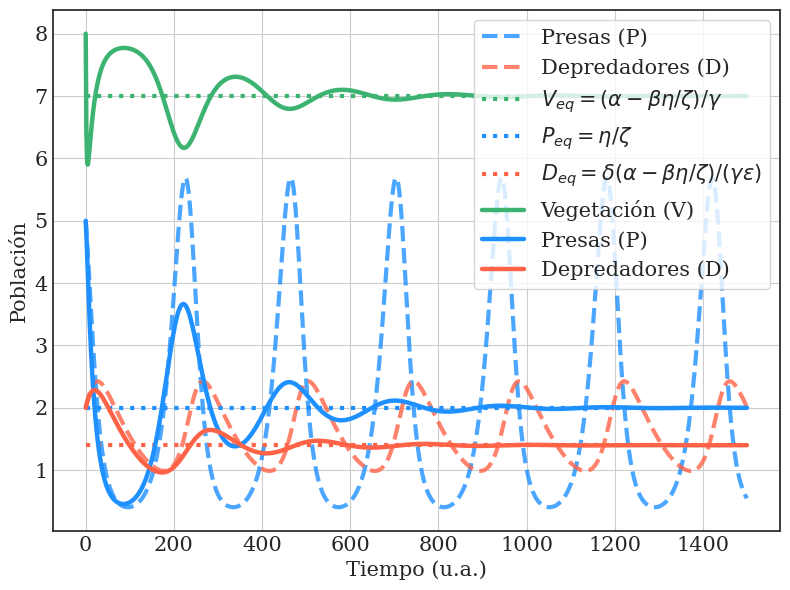

In [29]:
# Parámetros de estilo de la gráfica
tex_fonts = {
    "text.usetex": False,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 12,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

# Define the colors
color_vege = '#3CB371'  # Soft green
color_presas = '#1E90FF'  # Soft blue
color_dep = '#FF6347'  # Soft red

plt.figure(figsize=(8, 6))

# Lotka-Volterra
plt.plot(t, P, '--', label="Presas (P)", color=color_presas, alpha=0.8, linewidth=3)
plt.plot(t, D, '--', label="Depredadores (D)", color=color_dep, alpha=0.8, linewidth=3)

# Punto de equilibrio
plt.plot(t_e, t_e*0+V_eq, ':', label=r"$V_{eq}=(\alpha-\beta\eta/\zeta)/\gamma$", color=color_vege, linewidth=3)
plt.plot(t_e, t_e*0+P_eq, ':', label=r"$P_{eq}=\eta/\zeta$", color=color_presas,linewidth=3)
plt.plot(t_e, t_e*0+D_eq, ':', label=r"$D_{eq}=\delta(\alpha-\beta\eta/\zeta)/(\gamma\epsilon)$", color=color_dep, linewidth=3)
# Modelo extendido
plt.plot(t_e, V_e, label="Vegetación (V)", color=color_vege, linewidth=3.2)
plt.plot(t_e, P_e, label="Presas (P)", color=color_presas, linewidth=3.2)
plt.plot(t_e, D_e, label="Depredadores (D)", color=color_dep, linewidth=3.2)

# Improve labels and title
plt.xlabel("Tiempo (u.a.)", fontsize=15)
plt.ylabel("Población", fontsize=15)
plt.legend(fontsize=15, loc='upper right', frameon=True)

# Add grid for clarity
plt.grid(True)

# Adjust layout for better visibility
plt.tight_layout()
plt.savefig('Lotka_Volterra.png')



In [22]:
from scipy.linalg import eigvals

def jacobian(P, V):
    return np.array([[-V*gamma,           -beta*V,                   0],
                     [delta*P,             0,               -epsilon*P],
                     [0,        zeta*delta*V/epsilon,       zeta*P-eta]])

def stability(P, V):
    eigen_vals = eigvals(jacobian(P, V))
    return not True in [np.real(ii)>0 for ii in eigen_vals]

stability = np.vectorize(stability)

In [23]:
Eq_P, Eq_V = np.linspace(0, 50, 100), np.linspace(-10, 40, 100)
Eq_P, Eq_V = np.meshgrid(Eq_P, Eq_V)

stable = stability(Eq_P, Eq_V)

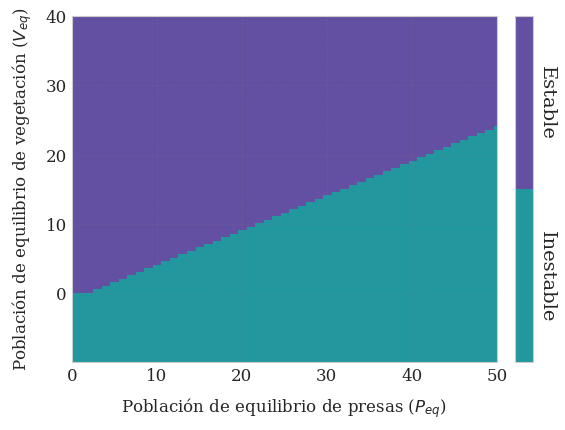

In [24]:
from matplotlib.colors import BoundaryNorm, ListedColormap

# Parámetros de estilo sin LaTeX pero profesional
tex_fonts = {
    "text.usetex": False,
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.linewidth": 0.8,
    "savefig.dpi": 300,
    "savefig.format": 'pdf',
    "savefig.bbox": 'tight'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update(tex_fonts)

# Definir colores y etiquetas binarias
cmap = ListedColormap(["#22989E", "#6450A3"])  # Celeste aún más vibrante y violeta más intenso

bounds = [0, 0.5, 1]  # Límites para separar los colores
norm = BoundaryNorm(bounds, cmap.N)

# Configuración de la figura
plt.figure(figsize=(6, 4.5))  # Proporción 4:3 estándar

im = plt.imshow(stable, 
                extent=[0, 50, -10, 40],  # Ajustado para evitar valores negativos en V_eq
                origin='lower', 
                cmap=cmap, 
                norm=norm,
                aspect='auto',          # Relación de aspecto automática
                interpolation='none')   # Sin interpolación para datos discretos

# Configuración de ejes
plt.xlabel(r'Población de equilibrio de presas ($P_{eq}$)', labelpad=8)
plt.ylabel(r'Población de equilibrio de vegetación ($V_{eq}$)', labelpad=8)
plt.xticks(np.linspace(0, 50, 6))
plt.yticks(np.linspace(0, 40, 5))

# Colorbar profesional
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(['Inestable', 'Estable'])
cbar.ax.tick_params(labelsize=14)

for label in cbar.ax.get_yticklabels():
    label.set_rotation(-90)       # Rotación de 45 grados
    label.set_va('center')       # Alineación vertical

# Gridlines transparentes
plt.grid(True, color='gray', linestyle=':', linewidth=0.4, alpha=0.5)

# Ajustes finales
plt.savefig('stability.png', dpi=300, transparent=True)